In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
from pyspark.ml.feature import OneHotEncoder, Word2Vec, StringIndexer, Tokenizer

In [2]:
spark = SparkSession \
.builder \
.master("spark://25.39.43.23:7077") \
.appName("Naive Bayes") \
.config("spark.executor.memory", "2g") \
.getOrCreate()

#"spark.executor.memory", "4g"

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/05 20:54:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df1 = spark.read.csv('hdfs://dmk:9000/SmallData/data1.csv', header=True, inferSchema=True).limit(1000)
df2 = spark.read.csv('hdfs://dmk:9000/SmallData/data2.csv', header=True, inferSchema=True).limit(1000)
df3 = spark.read.json('hdfs://dmk:9000/SmallData/data3.json').drop('_corrupt_record','element').withColumn('text', concat_ws(',', col('text'))).limit(1000)
df4 = spark.read.json('hdfs://dmk:9000/SmallData/data4.json').drop('_corrupt_record','element').withColumn('text', concat_ws(',', col('text'))).limit(1000)

In [4]:
bigdata = df1.union(df2)
      #       .union(df3)\
       #      .union(df4)

In [5]:
bigdata.printSchema()

root
 |-- date: string (nullable = true)
 |-- label: string (nullable = true)
 |-- page_index: integer (nullable = true)
 |-- sub_label: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



In [6]:
bigdata.show(5)

+--------------------+-------+----------+---------+--------------------+--------------------+
|                date|  label|page_index|sub_label|                text|                 url|
+--------------------+-------+----------+---------+--------------------+--------------------+
|13/12/2021 22:04:...|   null|      null|     null|                null|                null|
|                   "|Thời sự|         1|     null|"Ngày 13/12, Thàn...|            Trong đó|
|                null|   null|         1|     null|Sáng 13/12 theo g...|https://vietnamne...|
|13/12/2021 21:57:...|   null|      null|     null|                null|                null|
|                   "|Thời sự|         1|     null|Ngày 13/12, UBND ...|https://vietnamne...|
+--------------------+-------+----------+---------+--------------------+--------------------+
only showing top 5 rows



In [7]:
bigdata = bigdata.na.drop(subset='text')\
                 .na.drop(how='all',subset=['label', 'sub_label'])

In [8]:
# thay thế các label Null bằng các sublabel
bigdata = bigdata[['label','text']]

In [9]:
bigdata.show(5)

+-------+--------------------+
|  label|                text|
+-------+--------------------+
|Thời sự|"Ngày 13/12, Thàn...|
|Thời sự|Ngày 13/12, UBND ...|
|Thời sự|"Để phục vụ việc ...|
|Thời sự|Ngày 22/7/2021, B...|
|Thời sự|Sáng 13/12, đoàn ...|
+-------+--------------------+
only showing top 5 rows



In [10]:
from pyspark.ml import Pipeline
label_indexer = StringIndexer(inputCol = "label", \
                             outputCol = "label_index")
label_onehot = OneHotEncoder(inputCol = "label_index", \
                            outputCol = "label_onehot")

tokenizer = Tokenizer(inputCol="text", outputCol="words")
word2Vec = Word2Vec(vectorSize=100, minCount=5, \
                    inputCol="words", outputCol="features")


In [11]:

# Make a pipeline
prepro_pipe  = Pipeline(stages = [label_indexer, label_onehot, tokenizer, word2Vec])
pipe_data = prepro_pipe.fit(bigdata).transform(bigdata)

In [12]:
pipe_data.show(5)

+----------+--------------------+-----------+-------------+--------------------+--------------------+
|     label|                text|label_index| label_onehot|               words|            features|
+----------+--------------------+-----------+-------------+--------------------+--------------------+
|   Thời sự|Theo ghi nhận của...|        0.0|(5,[0],[1.0])|[theo, ghi, nhận,...|[-0.0514231019825...|
|Kinh Doanh|"Tổng số tài khoả...|        1.0|(5,[1],[1.0])|["tổng, số, tài, ...|[-0.0334185358596...|
|Kinh Doanh|Theo thông báo từ...|        1.0|(5,[1],[1.0])|[theo, thông, báo...|[-0.0195764724171...|
|Kinh Doanh|Đáng chú ý, xe ô ...|        1.0|(5,[1],[1.0])|[đáng, chú, ý,, x...|[0.00692616680584...|
|Kinh Doanh|Lão mai này thuộc...|        1.0|(5,[1],[1.0])|[lão, mai, này, t...|[-0.0310545437322...|
+----------+--------------------+-----------+-------------+--------------------+--------------------+
only showing top 5 rows



In [13]:
data_onehot = pipe_data[['features','label_index']].withColumnRenamed('label_index','label')
train, test = data_onehot.randomSplit([0.8, 0.2])
train.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.0923885219917...|  0.0|
|[-0.0878206428897...|  0.0|
|[-0.0833935225689...|  0.0|
|[-0.0812306730021...|  0.0|
|[-0.0808888802088...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [14]:
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# lr = LogisticRegression((maxIter=10, regParam=0.3, elasticNetParam=0.8))
lr = LogisticRegression()

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s" \
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

22/01/05 20:57:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/05 20:57:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/01/05 20:58:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/01/05 20:58:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Coefficients: 
DenseMatrix([[ 1.78901354e+02,  1.20748925e+02, -1.36058730e+02,
               1.23998258e+02, -1.34521103e+02,  1.80567054e+02,
              -2.15184164e+01,  3.44655284e+02, -1.55797262e+02,
               7.53588764e+01, -4.71148475e+01, -2.53779699e+02,
               4.28178797e+01, -4.96036227e+00, -9.86397299e+01,
              -1.06661303e+02, -8.44022998e+01,  1.11859368e+02,
               8.26253085e+01,  4.05395231e+01,  3.79189564e+00,
              -1.58585731e+02,  1.21874493e+02,  1.21300010e+02,
              -6.40746956e+01, -1.09400587e+02, -4.22086109e+01,
              -1.20779471e+01,  4.75574501e+01,  1.31329049e+02,
              -2.17379532e+01,  4.67841775e+01,  7.86857558e+01,
              -4.73715223e+01, -1.47774802e+02, -7.59491676e+01,
              -1.24572483e+01, -2.41439486e+00, -1.48431743e+02,
               2.34439397e+01,  8.70227901e+01, -5.91554864e+01,
               2.04279324e+02,  1.75993457e+02,  2.04068179e+02,
          

label 0: 0.020036429872495445
label 1: 0.0176
label 2: 0.011182108626198083
label 3: 0.015105740181268883
label 4: 0.0
label 5: 0.0
True positive rate by label:
label 0: 0.9705882352941176
label 1: 0.9012345679012346
label 2: 0.9565217391304348
label 3: 0.936
label 4: 0.99
label 5: 1.0
Precision by label:
label 0: 0.9545454545454546
label 1: 0.9299363057324841
label 2: 0.9565217391304348
label 3: 0.9212598425196851
label 4: 1.0
label 5: 1.0
Recall by label:
label 0: 0.9705882352941176
label 1: 0.9012345679012346
label 2: 0.9565217391304348
label 3: 0.936
label 4: 0.99
label 5: 1.0
F-measure by label:
label 0: 0.9625
label 1: 0.9153605015673981
label 2: 0.9565217391304348
label 3: 0.9285714285714286
label 4: 0.9949748743718593
label 5: 1.0
Accuracy: 0.9504447268106735
FPR: 0.014369005490635856
TPR: 0.9504447268106733
F-measure: 0.9503587258736124
Precision: 0.9504307243017042
Recall: 0.9504447268106733


In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


def confusion_matrix(y_test, y_pred):
    if len(y_test.shape) != 2:
        raise IOError('y_test must be a 2D array (Matrix)')
    elif len(y_pred.shape) != 2:
        raise IOError('y_pred must be a 2D array (Matrix)')

    confusion_matrix = np.zeros((y_test.shape[1], y_test.shape[1]))
    for i in range(y_test.shape[0]):
      indices = np.where(y_test[i] == 1)
      pred_indices = np.where(y_pred[i] == 1)
      for j in pred_indices[0]:
        if j not in indices[0]:
          for n in indices:
            confusion_matrix[n, j] += 1
        else:
          confusion_matrix[j, j] += 1
    #   for obs in range(0, len(y_pred[:, 0])):
    #       j = y_pred[obs, :].argmax()
    #       i = y_test[obs, :].argmax()
    #       cm[i, j] += 1

    # accuracy = 0.0
    # for i in range(0, cm.shape[1]):
    #     accuracy += cm[i, i]
    # accuracy /= len(y_test.argmax(axis=1))

    return confusion_matrix

# def confusion_matrix(y_test, y_pred):
#     if len(y_test.shape) != 2:
#         raise IOError('y_test must be a 2D array (Matrix)')
#     elif len(y_pred.shape) != 2:
#         raise IOError('y_pred must be a 2D array (Matrix)')

#     cm = np.zeros((y_test.shape[1], y_test.shape[1]))

#     for obs in range(0, len(y_pred[:, 0])):
#       # j = y_pred[obs, :].argmax()
#         # i = y_test[obs, :].argmax()
#         j = np.flatnonzero(y_pred[obs, :] == np.max(y_pred[obs, :]))
#         i = np.flatnonzero(y_test[obs, :] == np.max(y_test[obs, :]))
#         cm[i, j] += 1

#     return cm

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.ion()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if np.isnan(cm).any():
            np.nan_to_num(cm, copy=False)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ioff()


def draw_cm(y_test, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes, normalize)

    return cm

In [40]:
y_pred = lrModel.transform(test.select('features'))


In [41]:
y_true = test.select('label')

In [24]:
y_pred.show(3)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[-0.0820343963013...|[60.1408126335234...|[0.99999207709016...|       0.0|
|[-0.0756968745455...|[20.6703186298818...|[0.99999966170768...|       0.0|
|[-0.0720566094746...|[42.1852757135324...|[0.99999999999999...|       0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [27]:
y_true.show(3)

+-----+
|label|
+-----+
|  0.0|
|  0.0|
|  0.0|
+-----+
only showing top 3 rows



In [54]:
y_pred.show(1)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[-0.0820343963013...|[60.1408126335234...|[0.99999207709016...|       0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 1 row



In [55]:
y_pred1 = list(y_pred.toPandas()['prediction'])

In [58]:
y_true1 = list(y_true.toPandas()['label'])


In [46]:
y_true1 = list(y_true.toPandas())

In [67]:
import sklearn
import seaborn as sns

In [68]:
# classes = [x for x in range(6)]
# draw_cm(np.array([y_true1]), np.array([y_pred1]), classes, normalize=False)

In [69]:
from sklearn.metrics import confusion_matrix

temp = confusion_matrix(y_true1, y_pred1)

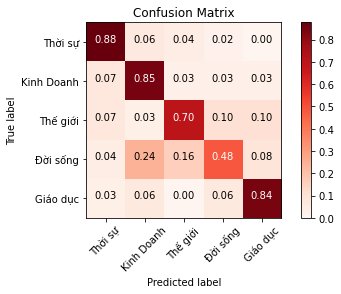

22/01/05 21:52:43 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
22/01/05 21:52:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:919)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:154)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:262)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:169)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.process(Inbox.scala:100)
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$Mess

In [77]:
classes = ['Thời sự', 'Kinh Doanh', 'Thế giới', 'Đời sống', 'Giáo dục']
plot_confusion_matrix(temp, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Reds)

In [76]:
DF = pipe_data.select('label', 'label_index').distinct().collect()

[Row(label='Du lịch', label_index=5.0),
 Row(label='Thời sự', label_index=0.0),
 Row(label='Kinh Doanh', label_index=1.0),
 Row(label='Đời sống', label_index=3.0),
 Row(label='Thế giới', label_index=2.0),
 Row(label='Giáo dục', label_index=4.0)]